In [1]:
import sys
import os
import os.path as path

import random
from scipy.stats import beta
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

sys.path.insert(1, path.join(path.abspath(path.pardir)))
import sims

In [2]:
# remove determinism
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

## Load datasets

In [3]:
# load probabilities
df = pd.read_csv("new_graph.csv")

In [4]:
users = df[['User', 'Group1']].drop_duplicates()
users.groupby('Group1').count()

,User
Group1,
A,356
B,375


## Parameters in the real network

In [5]:
users.groupby('Group1').count() / users.User.count()

,User
Group1,
A,0.487004
B,0.512996


## Propagation of the articles

In [6]:
# GLOBAL VARIABLES
TRIALS = 20
T      = 10
M      = 69

In [7]:
# UTIL METHODS

## plotting
def plot(df):
    '''Plot the lines in the dataframe.'''
    return sns.lineplot(x='t', y='n', data=df)


def plotgen(g):
    '''Plot the dataframe built from the generator.'''
    df = pd.DataFrame(g, columns=['t', 'nA', 'nB'])
    return plot(df)


## other
def filter_list(l, blacklist=[]):
    '''Filter out from a list the elements in `blacklist`.'''
    return [e for e in l if e not in blacklist]

### Propagation with the model

In [8]:
# model parameters
theta_opt = {1: 4.316992360088821e-11,
             -1: 0.9999999999745947}
pi, beta_dist, P, v, c, q = sims.get_params('twitter_uselections')
new_pi = {-1: 0.5, 1: 0.5}
params = theta_opt, T, new_pi, 2*M, P, beta_dist, v, c, q

In [21]:
# run unconstrained simulations
num_players_Aa, num_players_Ab, num_players_Ba, num_players_Bb = [], [], [], []

for a in [sims.runModel(*params)[1]
              for i in range(TRIALS)]:
    num_players_Aa.append(a[0] + [0] * (T - len(a[0])))
    num_players_Ab.append(a[1] + [0] * (T - len(a[1])))
    num_players_Ba.append(a[2] + [0] * (T - len(a[2])))
    num_players_Bb.append(a[3] + [0] * (T - len(a[3])))
    
Aa = pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)], 'n': np.array(num_players_Aa).reshape(-1)})
Ab = pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)], 'n': np.array(num_players_Ab).reshape(-1)})
Ba = pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)], 'n': np.array(num_players_Ba).reshape(-1)})
Bb = pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)], 'n': np.array(num_players_Bb).reshape(-1)})

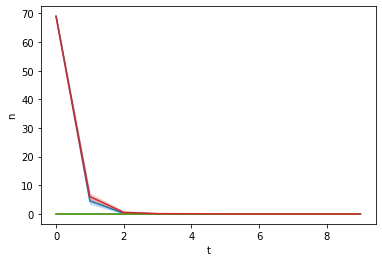

In [22]:
# plot results
sns.lineplot(x='t', y='n', data=Aa)
sns.lineplot(x='t', y='n', data=Ab)
sns.lineplot(x='t', y='n', data=Ba)
sns.lineplot(x='t', y='n', data=Bb)
plt.show()

### Propagation with the labeled network

In [23]:
def total_num_players(G):
    return len(G.User.unique())


def group_num_players(G):
    nA = G[['User', 'Group1']].drop_duplicates().query('Group1 == "A"').shape[0]
    nB = G[['User', 'Group1']].drop_duplicates().query('Group1 == "B"').shape[0]
    return nA, nB


def sample_seeds(df, group, size):
    '''Return dataframe with a random sample of users.'''
    # sample `size` users as the first set of users to see the article
    # we need to drop duplicates as we have a row for each (user, follower) pair
    seeds = (df[['User', 'Group1']].drop_duplicates()
                                   .query(f'Group1 == "{group}"')
                                   .sample(size)
                                   .User)
    # take the rows of the seed users
    G = df[df.User.isin(seeds)]
    return G


def propagate(df, group='A', article='Pa', steps=T, size=M, seed=0, func=group_num_players):
    '''Evaluates a function on each step of the propagation of an article through the network.'''
    blacklist = set([])
    G = sample_seeds(df, group, size).copy()
    for i in range(steps):
        yield (i,) + func(G)
        
        # toss a coin for each exposed user to determine whether or not they will share the article
        a = -1 if article == 'Pa' else 1
        g = -1 if   group ==  'A' else 1
        probs = np.random.beta(*beta_dist[(a, g)], size=G.shape[0])
        G.loc[:, 'Shared'] = np.random.binomial(1, p=probs).astype(bool)
        blacklist.update(set(G.User.tolist()))
        
        # take one friend for each user
        if not G.empty:
            newG = G.groupby('User').sample(1)
            newG = newG[newG.Shared].Follower.unique()
            newG = filter_list(newG, blacklist=blacklist)
            G = df[df.User.isin(newG)].copy()

In [24]:
def repeat_propagation(df, trials, **kwargs):
    for trial in range(trials):
        for result in propagate(df, seed=trial, **kwargs):
            yield result

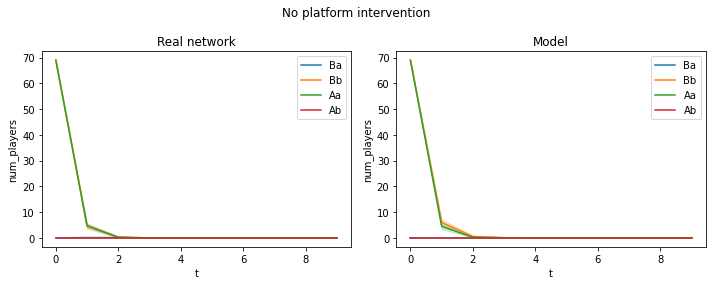

In [48]:
plt.figure(figsize=(10, 4))
plt.suptitle('No platform intervention')
plt.subplot(1, 2, 1)
a = pd.DataFrame(repeat_propagation(df, TRIALS, group='A', article='Pa'), columns=['t', 'nA', 'nB'])
b = pd.DataFrame(repeat_propagation(df, TRIALS, group='B', article='Pb'), columns=['t', 'nA', 'nB'])
sns.lineplot(x='t', y='nB', data=a)
sns.lineplot(x='t', y='nB', data=b)
sns.lineplot(x='t', y='nA', data=a)
g = sns.lineplot(x='t', y='nA', data=b)

#g.set_yscale("log")
g.legend(['Ba', 'Bb', 'Aa', 'Ab'])
g.set(ylabel='num_players')
g.set_title('Real network')
#plt.savefig('uselections.png', format='png', dpi=1200)

# plot model results
plt.subplot(1, 2, 2)

# plot results
sns.lineplot(x='t', y='n', data=Ba)
sns.lineplot(x='t', y='n', data=Bb)
sns.lineplot(x='t', y='n', data=Aa)
g = sns.lineplot(x='t', y='n', data=Ab)
g.set(ylabel='num_players')
g.legend(['Ba', 'Bb', 'Aa', 'Ab'])
g.set_title('Model')

#g.set_yscale("log")
plt.tight_layout()
plt.show()

TODO:
- intervention?
- other datasets